### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework_2

Mounted at /gdrive
/gdrive/My Drive/AN2DL/Homework_2


### Import libraries

In [58]:
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import logging
import random
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Flatten, Dense, LSTM, Reshape, Multiply, Dropout, Bidirectional, Attention
from keras.utils import plot_model

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

2.15.0


### Load data

In [3]:
# Unzip dataset
unzip = False

if unzip:
    !unzip training_dataset.zip

In [6]:
# Load and visualize dataset shape
dataset = np.load('training_data.npy')
dataset.shape

(48000, 2776)

In [7]:
start_end_dataset = np.load('valid_periods.npy')
start_end_dataset.shape

(48000, 2)

In [8]:
# Initialize a list to store reshaped time series (with their actual starting point)
reshaped_data = []

# Reshape the time series data using the valide_periods dataset
for i, (start, end) in enumerate(start_end_dataset):
    ts = dataset[i, start:end]  # Extracting the relevant portion of the time series
    reshaped_data.append(ts)

# Convert the list to a numpy array
reshaped_data = np.array(reshaped_data)

reshaped_data.shape


(48000,)

In [13]:
# Shuffle the data
np.random.shuffle(reshaped_data)
reshaped_data.shape

(48000,)

In [14]:
# Function to identify if a time series contains outliers based on Z-score
def contains_outliers(ts, threshold=3):
    if len(ts) == 0:  # Skip empty series
        return False
    mean = np.mean(ts)
    std = np.std(ts)
    z_scores = np.abs((ts - mean) / std)
    return np.any(z_scores > threshold)

# Filter the reshaped data to remove series with outliers
filtered_data = [ts for ts in reshaped_data if not contains_outliers(ts)]

# Convert the filtered list back to a numpy array
filtered_data = np.array(filtered_data, dtype=object)
print("Filtered dataset shape:", filtered_data.shape)

Filtered dataset shape: (38526,)


In [15]:
# Visualize the new dataset structure
first_time_series = filtered_data[3]
print(first_time_series)
print(filtered_data.shape)

[0.05123613 0.0430297  0.03908284 0.06454248 0.09173929 0.11911381
 0.17520464 0.16695551 0.20200195 0.17236814 0.12167203 0.09314721
 0.05943843 0.06077609 0.06946469 0.01999879 0.06251188 0.10450975
 0.03102657 0.02673944 0.03801381 0.         0.01907854 0.07970999
 0.08505787 0.06882134 0.02583573 0.03437141 0.00579699 0.00149884
 0.03259842 0.08097326 0.0776229  0.06953632 0.04709916 0.03989012
 0.015494   0.01398138 0.0212717  0.05618038 0.0943664  0.15425117
 0.14892946 0.14948601 0.15236247 0.16550213 0.17749837 0.19439202
 0.24034776 0.21602052 0.22553844 0.22323645 0.27413369 0.24663932
 0.25822641 0.23033804 0.33710018 0.33619371 0.33513158 0.39809118
 0.38831152 0.39084632 0.39308494 0.37277757 0.42646723 0.40458938
 0.41462803 0.41286744 0.45895682 0.50734956 0.57081199 0.5319537
 0.45933015 0.4603179  0.41658837 0.44868397 0.39970712 0.34972599
 0.35156373 0.35421287 0.3088743  0.30294368 0.29079177 0.26458409
 0.28081648 0.27761629 0.28416408 0.30937024 0.36330787 0.37598

In [18]:
# Training and Test splitting
train = []
test = []

# Loop through each row in the dataset
for index in range(filtered_data.shape[0]):
    time_series = filtered_data[index]  # Adjust indexing as needed

    # Define the ratio for splitting
    train_ratio = 0.8

    # Calculate lengths for training and test sets
    total_length = len(time_series)
    train_length = int(train_ratio * total_length)
    test_length = total_length - train_length

    # Split the time series data into training and test sets
    train_data = time_series[:train_length]
    test_data = time_series[train_length:]

    # Append the training and test data for the current time series to the lists
    train.append(train_data)
    test.append(test_data)

# Convert the lists to numpy arrays
train = np.array(train, dtype=object)
test = np.array(test, dtype=object)

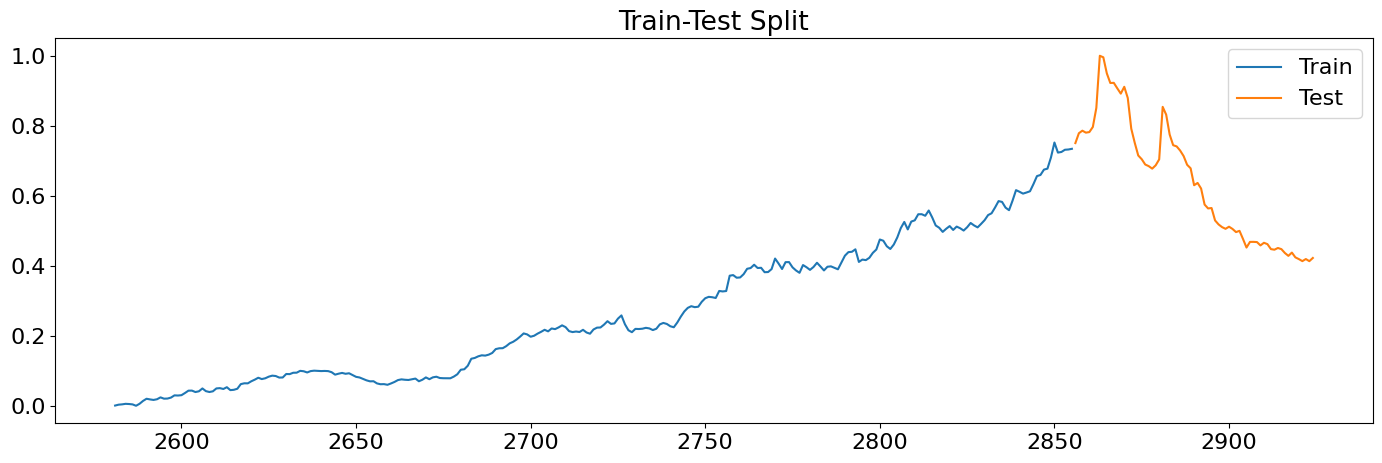

In [45]:
# Plot the train-test splitting
idx = 300
timestep = start_end_dataset[idx][0]  # Adjust the starting time step as needed

plt.figure(figsize=(17, 5))
plt.plot(range(timestep, timestep + len(train[idx])), train[idx], label='Train')

# Convert the floating-point values to integers using int()
start_test_idx = int(timestep + len(train[idx]))
end_test_idx = int(start_test_idx + len(test[idx]))

plt.plot(range(start_test_idx, end_test_idx), test[idx], label='Test')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [46]:
def create_sequences(series, window=200, stride=5, telescope=9):
    sequences = []
    labels = []

    padding_check = len(series) % window
    if padding_check != 0:
        # Compute padding length
        padding_len = window - padding_check
        padding = np.zeros(padding_len, dtype='float32')
        series = np.concatenate((series, padding), axis=0)
        assert len(series) % window == 0

    for i in range(0, len(series) - window - telescope + 1, stride):
        sequence = series[i:i + window]
        label = series[i + window:i + window + telescope]
        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

In [48]:
train_sequences = []
train_labels = []

window_size = 200  # Define your window size
stride = 5  # Define your stride
telescope = 18  # Define your telescope

for series in train:
    sequences, labels = create_sequences(series, window=window_size, stride=stride, telescope=telescope)
    train_sequences.extend(sequences)
    train_labels.extend(labels)

train_sequences = np.array(train_sequences)
train_labels = np.array(train_labels)

print("Train sequences shape:", train_sequences.shape)
print("Train labels shape:", train_labels.shape)

Train sequences shape: (550108, 200)
Train labels shape: (550108, 18)


In [49]:
train_sequences_reshaped = train_sequences.reshape(train_sequences.shape[0], train_sequences.shape[1], 1)
train_labels_reshaped = train_labels.reshape(train_labels.shape[0], train_labels.shape[1], 1)

print("Train sequences shape after reshaping:", train_sequences_reshaped.shape)
print("Train labels shape after reshaping:", train_labels_reshaped.shape)

Train sequences shape after reshaping: (550108, 200, 1)
Train labels shape after reshaping: (550108, 18, 1)


In [50]:
test_sequences = []
test_labels = []

# Creating sequences for each series in the test data
for series in test:
    sequences, labels = create_sequences(series, window=window_size, stride=stride, telescope=telescope)
    test_sequences.extend(sequences)
    test_labels.extend(labels)

test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

print("Test sequences shape:", test_sequences.shape)
print("Test labels shape:", test_labels.shape)

Test sequences shape: (595, 200)
Test labels shape: (595, 18)


# Model

In [52]:
input_shape = train_sequences_reshaped.shape[1:]
output_shape = train_labels_reshaped.shape[1:]
batch_size = 64
epochs = 200

In [53]:
train_sequences_reshaped.shape, train_labels_reshaped.shape

((550108, 200, 1), (550108, 18, 1))

In [54]:
print(input_shape)
print(output_shape)

(200, 1)
(18, 1)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_7 (Conv1D)           (None, 200, 64)              512       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 200, 64)              256       ['conv1d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_7 (Activation)   (None, 200, 64)              0         ['batch_normalization_7[

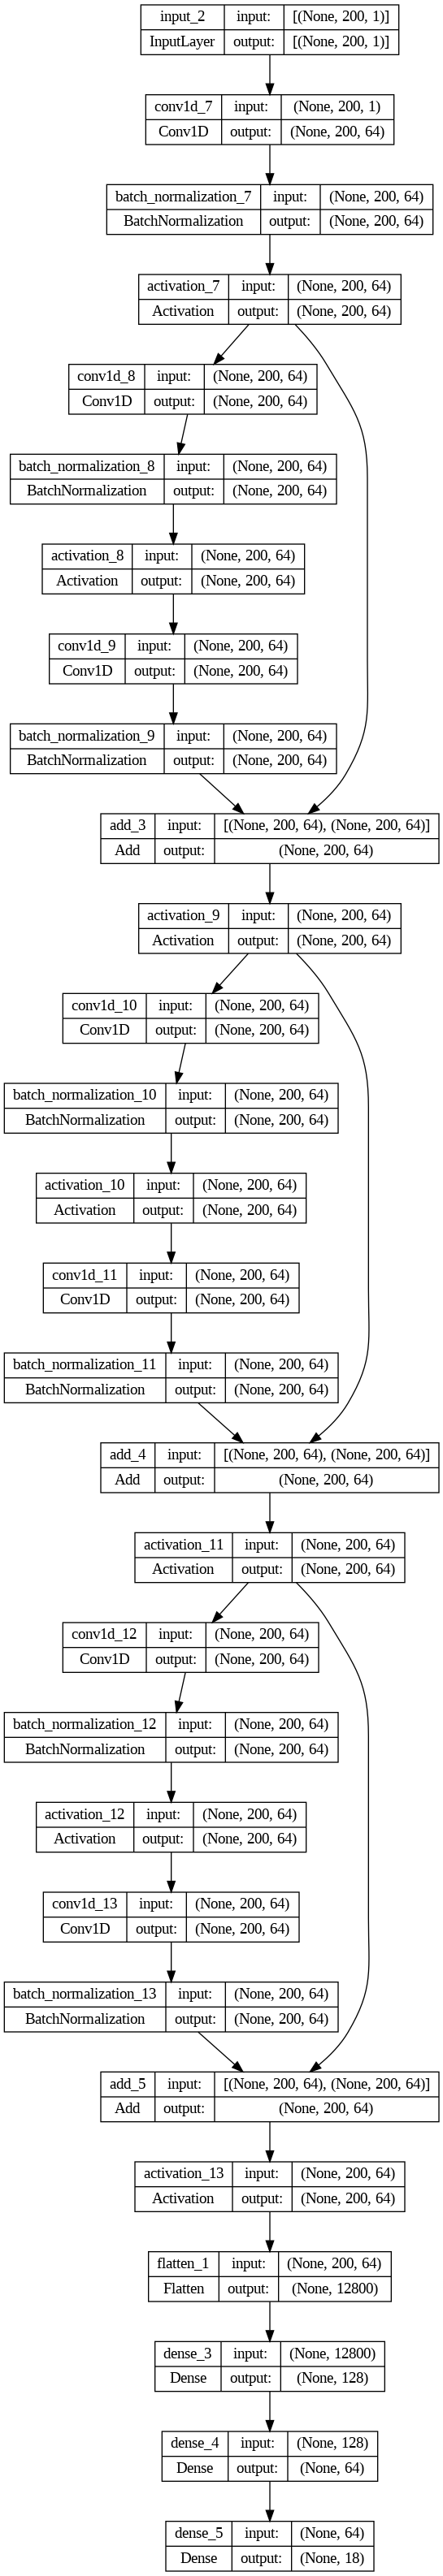

In [59]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resnet(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Initial Conv1D layer
    x = Conv1D(64, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for _ in range(3):  # You can adjust the number of residual blocks
        x = residual_block(x, 64)

    # Global average pooling
    x = Flatten()(x)

    # Dense layers for regression
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Output layer for regression
    outputs = Dense(output_shape[0] * output_shape[1])(x)

    # Create model
    model = Model(inputs, outputs)

    return model

# Build the model
model = build_resnet(input_shape)

# Compile the model for regression
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

plot_model(model,to_file='resnet.png',show_shapes=True)


In [ ]:
# Train the model
history = model.fit(
    x = train_sequences_reshaped,
    y = train_labels_reshaped,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1317/1317 [==============================] - 102s 70ms/step - loss: 0.1375 - mae: 0.1046 - val_loss: 0.0131 - val_mae: 0.0621 - lr: 0.0010
Epoch 2/200
1317/1317 [==============================] - 92s 70ms/step - loss: 0.0119 - mae: 0.0575 - val_loss: 0.0116 - val_mae: 0.0577 - lr: 0.0010
Epoch 3/200
1317/1317 [==============================] - 93s 70ms/step - loss: 0.0111 - mae: 0.0549 - val_loss: 0.0108 - val_mae: 0.0547 - lr: 0.0010
Epoch 4/200
1317/1317 [==============================] - 94s 71ms/step - loss: 0.0105 - mae: 0.0530 - val_loss: 0.0110 - val_mae: 0.0597 - lr: 0.0010
Epoch 5/200
1317/1317 [==============================] - 89s 68ms/step - loss: 0.0099 - mae: 0.0500 - val_loss: 0.0098 - val_mae: 0.0498 - lr: 0.0010
Epoch 6/200
1317/1317 [==============================] - 94s 71ms/step - loss: 0.0095 - mae: 0.0474 - val_loss: 0.0104 - val_mae: 0.0522 - lr: 0.0010
Epoch 7/200
1317/1317 [==============================] - 93s 71ms/step - loss: 0.0091 - mae: 0.0451

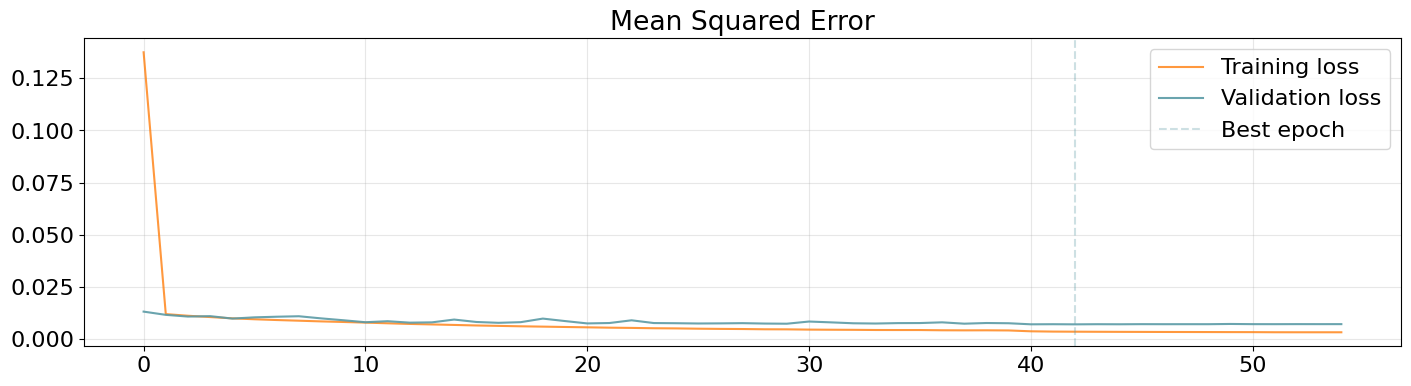

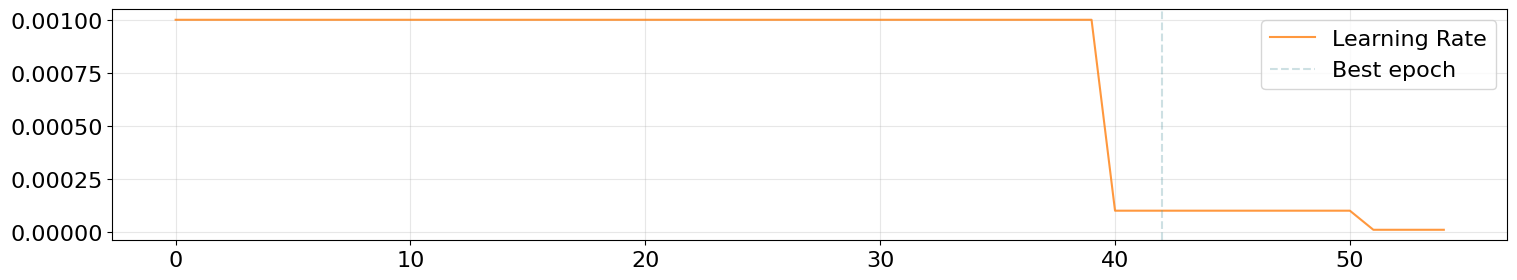

In [ ]:
# Visualize the history of the training and validation loss
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('resnet')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(test_sequences, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (212013, 9)
Mean Squared Error: 0.006939629092812538
Mean Absolute Error: 0.031023206189274788


In [60]:
del model